In [1]:
import pandas as pd
import numpy as np 
import pickle
from tensorflow import keras
import tensorflow as tf
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc
from collections import OrderedDict

In [2]:
# import hyperparameter search results

hp_results = pickle.load(open('data/classifier/classifier_hp_results.p', 'rb'))

In [3]:
# function for building an MLP model

class GeneClassifier:
    
    def __init__(self, X_train, y_train):
        
        self.X_train = X_train
        self.y_train = y_train

    def build_best_model(self, trials):
        
        trials = trials.sort_values('value', ascending = False)
        best_params = trials.iloc[0, :]
        lr = best_params['params_lr']
        hidden_layer_size = best_params['params_hidden_layer_size']
        activation = best_params['params_activation']
        hidden_dropout_rate = best_params['params_hidden_dropout_rate']
        hidden_layer_size = best_params['params_hidden_layer_size']
        num_epochs = best_params['params_num_epochs']
        l2_regularization = best_params['params_l2_regularization']
        
        final_layer_activation = 'softmax' if len(self.y_train.shape) > 1 else 'sigmoid'
        final_layer_size = 1 if len(self.y_train.shape) == 1 else self.y_train.shape[1]
        loss_func = 'categorical_crossentropy' if len(self.y_train.shape) > 1 else 'binary_crossentropy'
        metric = 'accuracy' if len(self.y_train.shape) > 1 else keras.metrics.AUC()
        
        model = keras.Sequential([keras.layers.InputLayer(input_shape = (self.X_train.shape[1],)), 
                                  keras.layers.Dense(hidden_layer_size, activation = activation, 
                                                     kernel_regularizer = keras.regularizers.l2(l2_regularization),
                                                     kernel_initializer = 'glorot_normal'),
                                  keras.layers.Dropout(hidden_dropout_rate),
                                  keras.layers.Dense(final_layer_size, 
                                                     activation = final_layer_activation,
                                                     kernel_initializer = 'glorot_normal')])
        
        model.compile(loss = loss_func, 
                      optimizer = keras.optimizers.Adam(learning_rate = lr),
                      metrics = [metric])
        
        model.fit(self.X_train, self.y_train, epochs = num_epochs, verbose = 0, batch_size = len(self.X_train))
        
        return model

In [4]:
# fit models on train set, get predictions for test set

np.random.seed(123)
tf.random.set_seed(123)

model_names = {'custom': 'Hierarchical TransR',
               'transR': 'TransR',
               'transE': 'TransE',
               'convE': 'ConvE',
               'complEx': 'ComplEx'}

roc_results = OrderedDict()
train, test = hp_results['train'], hp_results['test']

# loop through target values
for target in hp_results['targets']:
    y = hp_results['targets'][target]
    roc_results[target] = OrderedDict()
    # loop through models
    for model in hp_results[target]:
        # build classifier, predict
        X = hp_results['embeddings'][model]
        clf = GeneClassifier(X[train], y[train])
        predictor = clf.build_best_model(hp_results[target][model])
        y_pred = predictor.predict(X[test])
        model_name = model_names[model]
        # if multi-class prediction, get predictions for each class
        if y_pred.shape[1] > 1:
            for i in range(y_pred.shape[1]):
                category_preds = y_pred[:,i]
                category_true = y[test][:,i]
                if i not in roc_results[target]:
                    roc_results[target][i] = OrderedDict()
                roc_results[target][i][model_name] = roc_curve(category_true, category_preds)
        else:    
            # save ROC results
            roc_results[target][model_name] = roc_curve(y[test], y_pred)

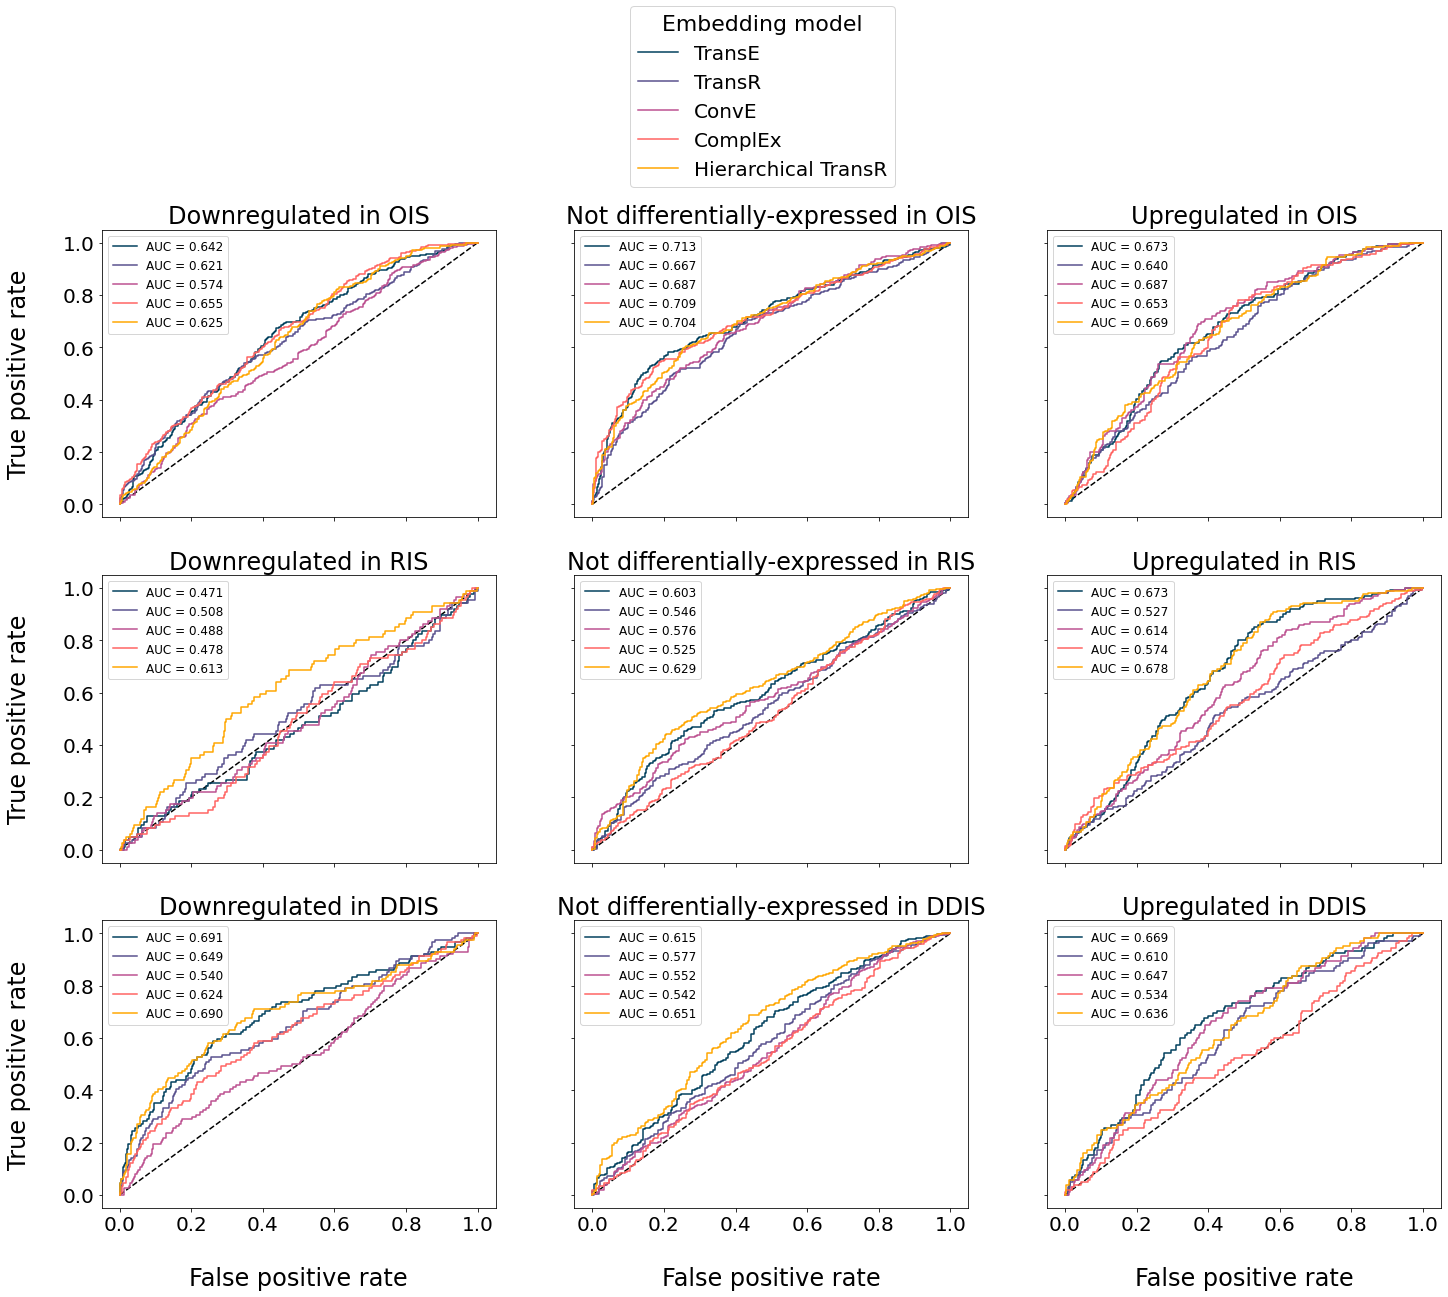

In [118]:
import matplotlib.pyplot as plt
from itertools import product

plt.rcParams['font.size'] = 20
colors = {'TransE': '#003f5c', 
          'TransR': '#58508d', 
          'ConvE': '#bc5090',
          'ComplEx': '#ff6361', 
          'Hierarchical TransR': '#ffa600'}
titles = ['Downregulated in OIS',
          'Not differentially-expressed in OIS', 
          'Upregulated in OIS',
          'Downregulated in RIS', 
          'Not differentially-expressed in RIS', 
          'Upregulated in RIS',  
          'Downregulated in DDIS',
          'Not differentially-expressed in DDIS', 
          'Upregulated in DDIS']

senescence_subtype_rocs = OrderedDict({k: roc_results[k] for k in ['oncogene', 'replicative', 'DNA damage']})
senescence_subtype_aucs = OrderedDict()

fig, axs = plt.subplots(3, 3, sharey = True, sharex = True, figsize = (24, 18))

legend_labels = []
i = 0
for subtype in senescence_subtype_rocs:
    j = 0
    senescence_subtype_aucs[subtype] = {}
    for target in senescence_subtype_rocs[subtype]:
        title = titles[i*3 + j]
        axs[i, j].plot([0, 1], [0, 1], 'k--')
        senescence_subtype_aucs[subtype][target] = {}
        for model in senescence_subtype_rocs[subtype][target]:
            fpr, tpr, _ = senescence_subtype_rocs[subtype][target][model]
            clf_auc = auc(fpr, tpr)
            senescence_subtype_aucs[subtype][target][model] = clf_auc
            axs[i, j].step(fpr, tpr, label = 'AUC = {:.3f}'.format(clf_auc), color = colors[model])
        if i == 2:
            axs[i, j].set_xlabel('\nFalse positive rate', fontsize = 24)
        if j == 0:
            axs[i, j].set_ylabel('True positive rate\n', fontsize = 24)
        axs[i, j].set_title(title, fontsize = 24)
        axs[i, j].legend(fontsize = 12)
        j += 1
    i += 1
    
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, senescence_subtype_rocs[subtype][target].keys(), 
           title = 'Embedding model', bbox_to_anchor = [0.59, 1.06],
           fontsize = 20, title_fontsize = 22)

plt.savefig('../figures/fig5a.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight')

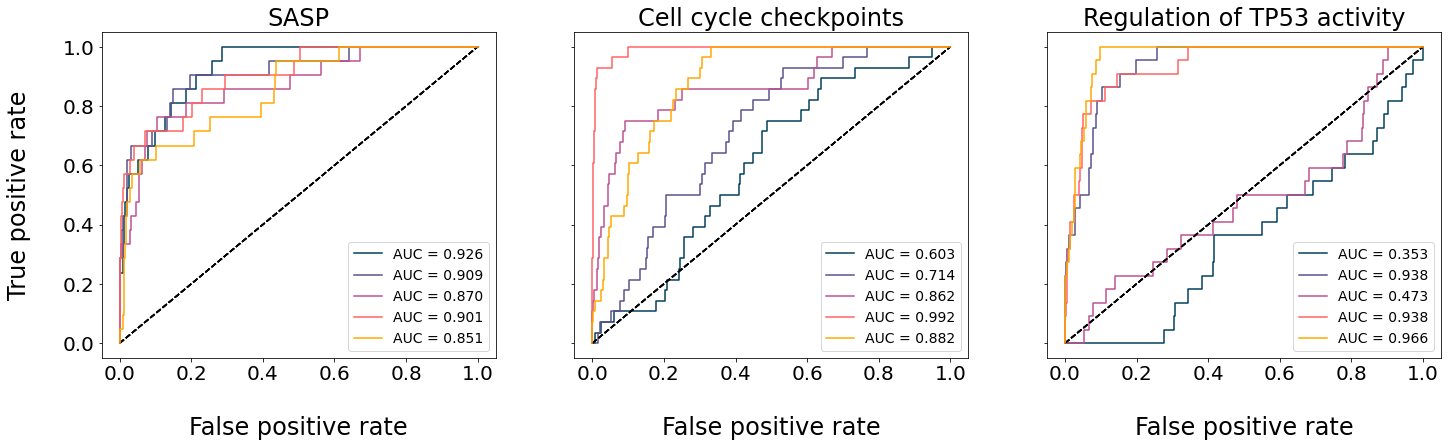

In [119]:
import matplotlib.pyplot as plt
from itertools import product

plt.rcParams['font.size'] = 20
titles = ['SASP',
          'Cell cycle checkpoints',
          'Regulation of TP53 activity']

pathway_rocs = OrderedDict({k: roc_results[k] for k in ['SASP', 'Cell cycle checkpoint', 'TP53 regulation']})
pathway_aucs = {}

fig, axs = plt.subplots(1, 3, sharey = True, sharex = False, figsize = (24, 6))

for i, pathway in enumerate(pathway_rocs):
    title = titles[i]
    pathway_aucs[pathway] = {}
    for model in pathway_rocs[pathway]:
        axs[i].plot([0, 1], [0, 1], 'k--')
        fpr, tpr, _ = pathway_rocs[pathway][model]
        clf_auc = auc(fpr, tpr)
        pathway_aucs[pathway][model] = clf_auc
        axs[i].step(fpr, tpr, label = 'AUC = {:.3f}'.format(clf_auc), color = colors[model])
    axs[i].set_xlabel('\nFalse positive rate', fontsize = 24)
    if i == 0:
        axs[i].set_ylabel('True positive rate\n', fontsize = 24)
    axs[i].set_title(title, fontsize = 24)
    axs[i].legend(fontsize = 14)
        
plt.savefig('../figures/fig5b.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight')